<a href="https://colab.research.google.com/github/JuanPedroDelCastillo/FisicaComputacional1/blob/master/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 6

Importar Bibliotecas

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

Celda para configurar Dataframe df_meteo

In [272]:
# Tomar la dirección URL del archivo en formato 'raw'
url = "https://raw.githubusercontent.com/JuanPedroDelCastillo/FisicaComputacional1/master/Actividad5/26139.txt"
url2 = "https://raw.githubusercontent.com/JuanPedroDelCastillo/FisicaComputacional1/master/Actividad5/26032.txt"

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')
df2_dist = pd.read_csv(url2, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')


# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()
df2_work0 = df2_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)
df2_work1 = df2_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')
  df2_work1[cols] = pd.to_numeric(df2_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()
df2_work2 = df2_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()
df2_work2['Fecha']=pd.to_datetime(df2_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

df2_work2['Año'] = df2_work2['Fecha'].dt.year
df2_work2['Mes'] = df2_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()
df_meteo.info()

df2_meteo = df2_work2.copy()
df2_meteo.info()

# Serie de Tiempo
# Primero realizamos una copia del Dataframe
df_meteo_ts = df_meteo.copy()
df2_meteo_ts = df2_meteo.copy()

# Redefinimos que el índice de este Dataframe sea la fecha 
df_meteo_ts = df_meteo_ts.set_index("Fecha")
df2_meteo_ts = df2_meteo_ts.set_index("Fecha")

# Definimos conjuntos de años de 30 años
df_60 = df_meteo_ts[(df_meteo_ts["Año"]>=1960)&(df_meteo_ts["Año"]<1990)]
df_90 = df_meteo_ts[(df_meteo_ts["Año"]>=1990)&(df_meteo_ts["Año"]<2018)]

df2_90 = df2_meteo_ts[(df2_meteo_ts["Año"]>=1996)&(df2_meteo_ts["Año"]<2015)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19301 entries, 0 to 19300
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   19301 non-null  datetime64[ns]
 1   Precip  19291 non-null  float64       
 2   Evap    10285 non-null  float64       
 3   Tmax    19121 non-null  float64       
 4   Tmin    19138 non-null  float64       
 5   Año     19301 non-null  int64         
 6   Mes     19301 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26110 entries, 0 to 26109
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   26110 non-null  datetime64[ns]
 1   Precip  26085 non-null  float64       
 2   Evap    23994 non-null  float64       
 3   Tmax    26031 non-null  float64       
 4   Tmin    26037 non-null  float64       

# Estacionaridad

## Probar Estacionaridad de una Serie de Tiempo

In [273]:
# Definimos una función como test de la estacionaridad de una serie de tiempo

def test_stationarity(df_ts):

  # Estadística de Promedios Móviles
  rolmean = df_ts.rolling(window=365, center=True).mean()
  rolstd = df_ts.rolling(window=365, center=True).std()

  # Gráfica de la estadística
  plt.rcParams['figure.figsize'] = (12, 6)
  plt.plot(df_ts, color='blue', label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label='Rolling Std Deviation')
  plt.legend(loc='best')
  plt.title('Promedio Móvil y Desviación Estaádar')
  plt.grid()
  plt.show()

  #Prueba aumentada de Dickey-Fuller
  #Si el valor es menor al 5% entonces la serie es estacionaria
  print('Resultados de la Prueba de Dickey-Fuller:')
  dftest = adfuller(df_ts, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                       index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)
  

In [274]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2010-01', '2015-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2010-01-01,0.0,NaN,26.0,9.0,2010,Jan
2010-01-02,0.0,NaN,24.5,8.0,2010,Jan
2010-01-03,0.0,NaN,27.5,10.0,2010,Jan
2010-01-04,0.0,NaN,27.5,11.0,2010,Jan
2010-01-05,0.0,NaN,27.0,9.5,2010,Jan


Probamos estacionaridad de la Temperatura Máxima

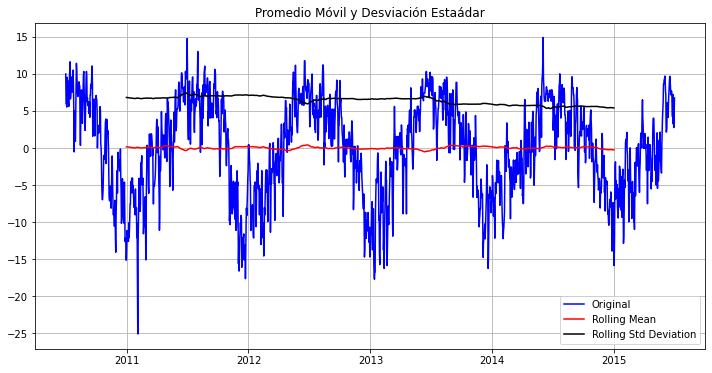

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.365928
p-value                           0.012177
#Lags Used                       13.000000
Number of Observations Used    1813.000000
Critical Value (1%)              -3.433962
Critical Value (5%)              -2.863136
Critical Value (10%)             -2.567619
dtype: float64


In [275]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()
moving_avg = ts_test.rolling(365, center=True).mean()
ts_test_moving_ave_diff = ts_test - moving_avg 
ts_test_moving_ave_diff.dropna(inplace=True)
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test_moving_ave_diff)

La p es menor al 5% por lo tanto pasó la prueba y la Temperatura Máxima es estacionaria en el periodo 2010-2015

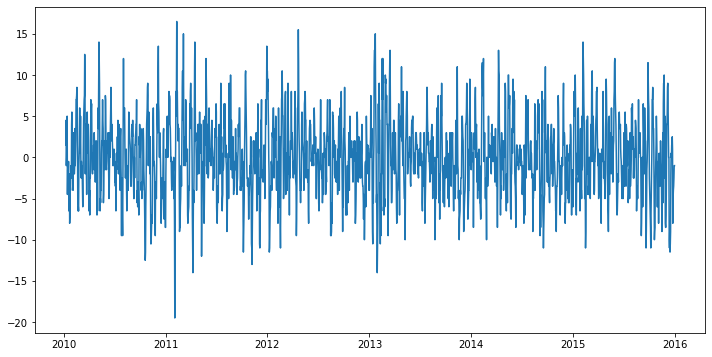

In [276]:
# Diferenciamos usando la función df.shift()
ts_test_diff = ts_test - ts_test.shift(periods=7)
plt.plot(ts_test_diff);

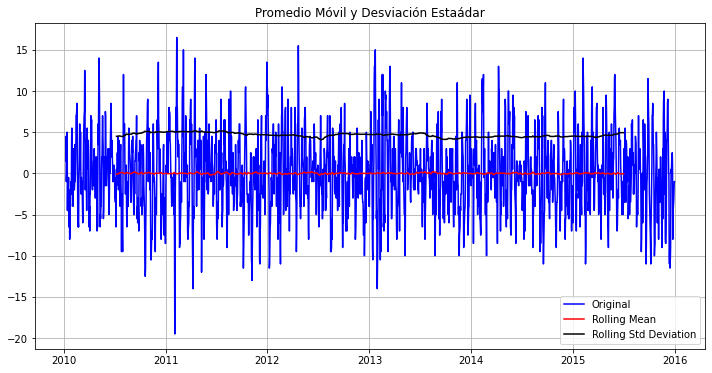

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.067573e+01
p-value                        4.058708e-19
#Lags Used                     2.600000e+01
Number of Observations Used    2.157000e+03
Critical Value (1%)           -3.433385e+00
Critical Value (5%)           -2.862881e+00
Critical Value (10%)          -2.567484e+00
dtype: float64


In [277]:
# Probamos la estacionaridad
ts_test_diff.dropna(inplace=True)
test_stationarity(ts_test_diff)

In [278]:
# Número de datos utilizados
len(ts_test_diff)

2184

Probamos estacionaridad de la Temperatura Mínima

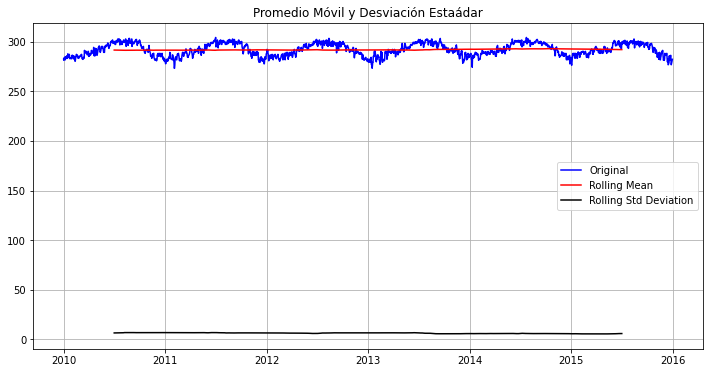

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.567239
p-value                           0.099959
#Lags Used                       14.000000
Number of Observations Used    2176.000000
Critical Value (1%)              -3.433359
Critical Value (5%)              -2.862869
Critical Value (10%)             -2.567478
dtype: float64


In [279]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test2 = ts_90['Tmin'].copy()

# Convertimos las temperaturas a grado Kelvin
def Kelvin(C):
  K = C + 273.15
  return K
ts_test2 = ts_test2.apply(Kelvin)

# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test2)

La p es mayor al 5% por lo tanto pasó la prueba y la Temperatura Mínima no es estacionaria en el periodo 2010-2015

Para reducir la p podemos reducir la tendencia o la estanionalidad

Para reducir la tendencia hacemos un cambio de escala: log(x), sqrt(x), raiz_cúbica(x),...

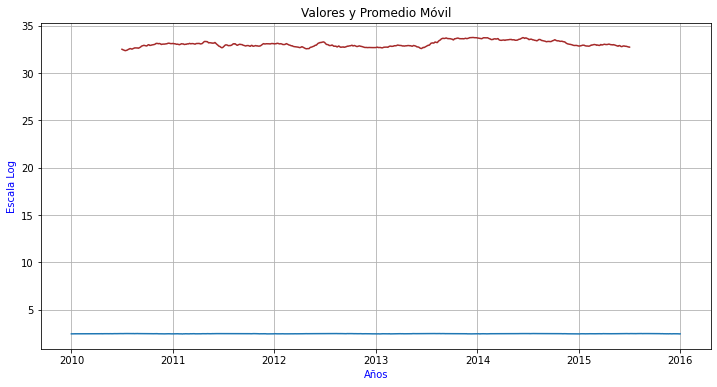

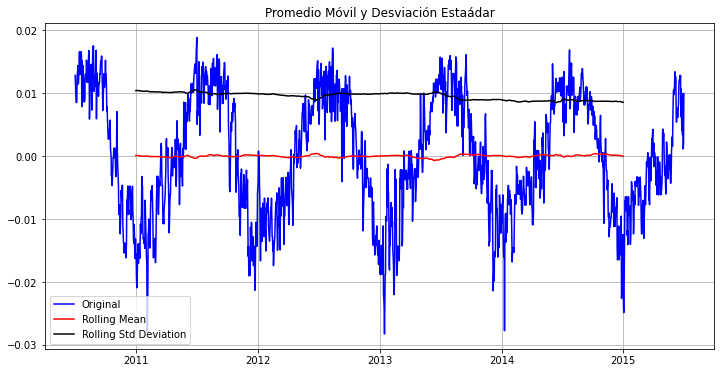

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.939718
p-value                           0.040920
#Lags Used                       10.000000
Number of Observations Used    1816.000000
Critical Value (1%)              -3.433956
Critical Value (5%)              -2.863133
Critical Value (10%)             -2.567618
dtype: float64


In [280]:

# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test2)

# calculamos el Promedio móvil de ts_test_log con ventana de 365
moving_avg2 = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

ts_test_log_moving_ave_diff = ts_test_log - moving_avg2 
ts_test_log_moving_ave_diff.dropna(inplace=True)
test_stationarity(ts_test_log_moving_ave_diff)


La p es menor al 5% por lo tanto pasó la prueba y la Temperatura Mínima escalada en log es estacionaria en el periodo 2010-2015

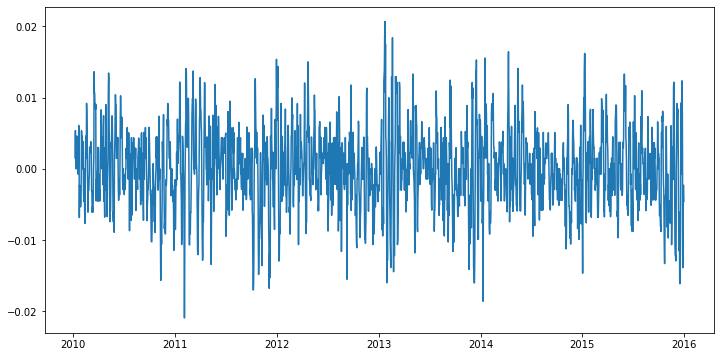

In [281]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

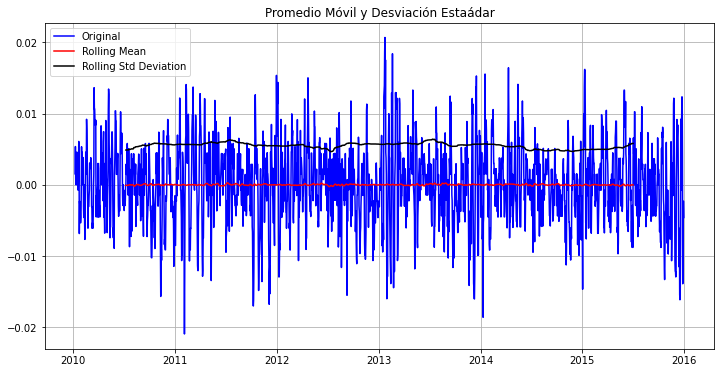

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.808777e+00
p-value                        5.730987e-17
#Lags Used                     2.100000e+01
Number of Observations Used    2.162000e+03
Critical Value (1%)           -3.433378e+00
Critical Value (5%)           -2.862878e+00
Critical Value (10%)          -2.567482e+00
dtype: float64


In [282]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [283]:
# Número de datos utilizados
len(ts_test_log_diff)

2184

# Pronóstico de Serie de Tiempo

## ARIMA (Auto Regresive Integrated Moving Average)

El método ARIMA es similar a una ecuación de regresión lineal donde la predicción depende de los parámetros (p,d,q) del modelo ARIMA.

*   p: es el número de términos AR (Auto-Regresivos). Por ej. si p=3, el predictor de y(t) serán los términos y(t-1), y(t-2), y(t-3).

*   q: es el orden de términos del promedio móvil MA (Moving-Average). Por ej. si q=3, los términos para estimar el predictor de y(t) serán los términos y(t-1), y(t-2), y(t-3).

*   d: es el número de diferenciaciones para hacer la serie estacionaria. 

Para determinar los valores de p y q, se utilizan métodos gráficos y son: 

*   La Función de Autocorrelación (ACF), la cual compara la correlación entre dos valores consecutivos pero con un retraso (lag).

*   La Función de Autocorrelación Parcial (PACF), que mide el grado de asociación del valor y(t) y y(t-p). 

















### Temperatura Máxima

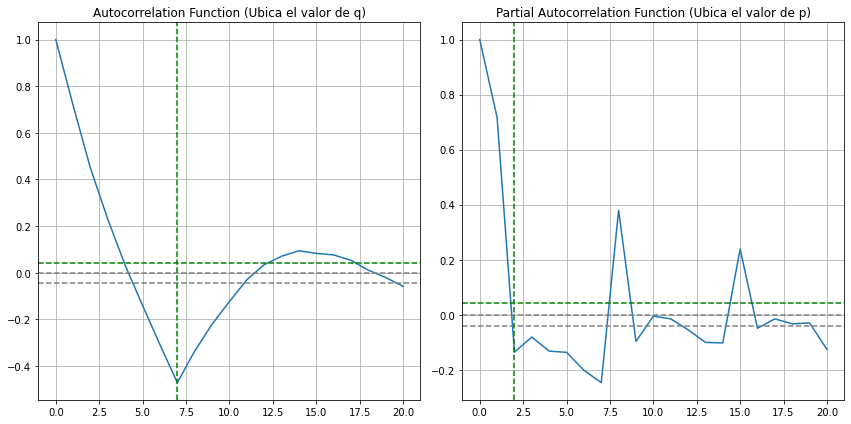

In [284]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_diff, nlags=20)
lag_pacf = pacf(ts_test_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=7, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2190
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -5050.665
Method:                       css-mle   S.D. of innovations              2.429
Date:                Fri, 19 Feb 2021   AIC                          10109.330
Time:                        06:49:40   BIC                          10132.097
Sample:                    01-02-2010   HQIC                         10117.651
                         - 12-31-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0017      0.045     -0.037      0.970      -0.089       0.086
ar.L1.D.Tmax    -0.0238      0.021     -1.125      0.261      -0.065       0.018
ar.L2.D.Tmax    -0.1378      0.021     -6.50

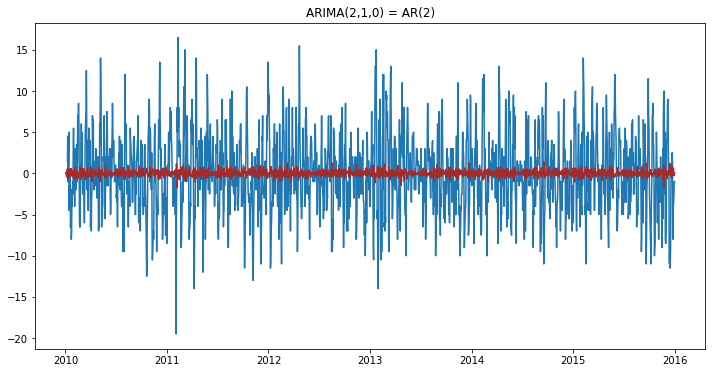

In [285]:
# Modelo AR(p): (p,d,q) = (2,1,0)
model = ARIMA(ts_test, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2190
Model:                 ARIMA(0, 1, 7)   Log Likelihood               -4961.133
Method:                       css-mle   S.D. of innovations              2.331
Date:                Fri, 19 Feb 2021   AIC                           9940.267
Time:                        06:49:44   BIC                           9991.492
Sample:                    01-02-2010   HQIC                          9958.989
                         - 12-31-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0016      0.015     -0.108      0.914      -0.030       0.027
ma.L1.D.Tmax    -0.1116      0.021     -5.201      0.000      -0.154      -0.070
ma.L2.D.Tmax    -0.2140      0.022     -9.87

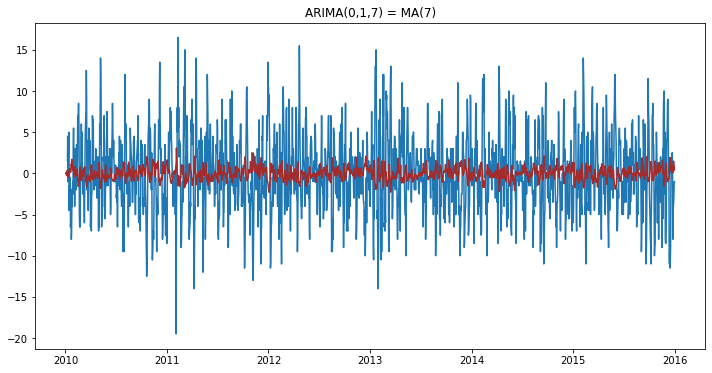

In [286]:
# Modelo MA(q): (p,d,q) = (0,1,7) 
model = ARIMA(ts_test, order=(0,1,7), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,7) = MA(7)')
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2190
Model:                 ARIMA(2, 1, 7)   Log Likelihood               -4959.117
Method:                       css-mle   S.D. of innovations              2.329
Date:                Fri, 19 Feb 2021   AIC                           9940.233
Time:                        06:49:53   BIC                          10002.842
Sample:                    01-02-2010   HQIC                          9963.116
                         - 12-31-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0016      0.015     -0.109      0.913      -0.030       0.027
ar.L1.D.Tmax    -0.8919      0.337     -2.646      0.008      -1.553      -0.231
ar.L2.D.Tmax    -0.1925      0.272     -0.70

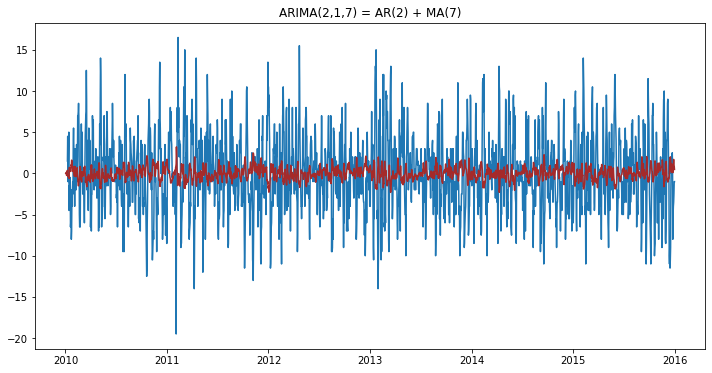

In [287]:
# Modelo ARIMA(p): (p,d,q) = (2,1,7) 
model = ARIMA(ts_test, order=(2,1,7), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,7) = AR(2) + MA(7)')
print(results_ARIMA.summary())

### Temperatura Mínima

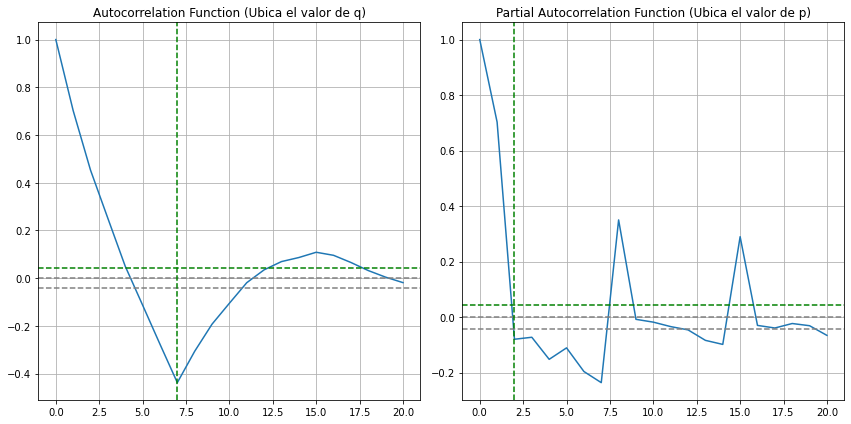

In [288]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=7, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2190
Model:                 ARIMA(2, 1, 0)   Log Likelihood                9651.061
Method:                       css-mle   S.D. of innovations              0.003
Date:                Fri, 19 Feb 2021   AIC                         -19294.123
Time:                        06:50:04   BIC                         -19271.356
Sample:                    01-02-2010   HQIC                        -19285.802
                         - 12-31-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.166e-07   5.04e-05     -0.004      0.997   -9.91e-05    9.86e-05
ar.L1.D.Tmin    -0.1248      0.021     -5.885      0.000      -0.166      -0.083
ar.L2.D.Tmin    -0.1253      0.021     -5.91

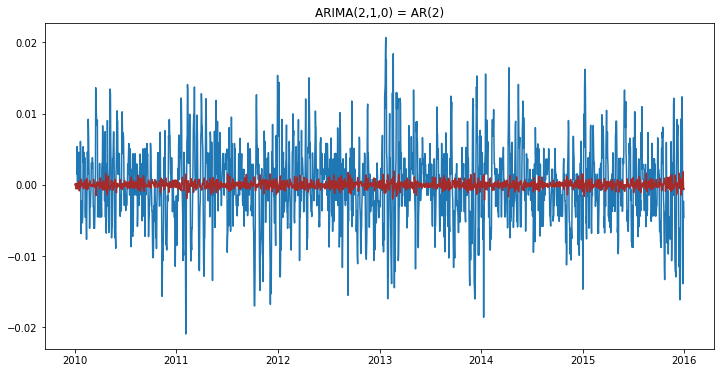

In [289]:
# Modelo AR(p): (p,d,q) = (2,1,0)
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR2 = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2190
Model:                 ARIMA(0, 1, 7)   Log Likelihood                9718.173
Method:                       css-mle   S.D. of innovations              0.003
Date:                Fri, 19 Feb 2021   AIC                         -19418.346
Time:                        06:50:09   BIC                         -19367.121
Sample:                    01-02-2010   HQIC                        -19399.623
                         - 12-31-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.027e-06   2.09e-05     -0.049      0.961   -4.19e-05    3.99e-05
ma.L1.D.Tmin    -0.1913      0.021     -8.947      0.000      -0.233      -0.149
ma.L2.D.Tmin    -0.1712      0.022     -7.85

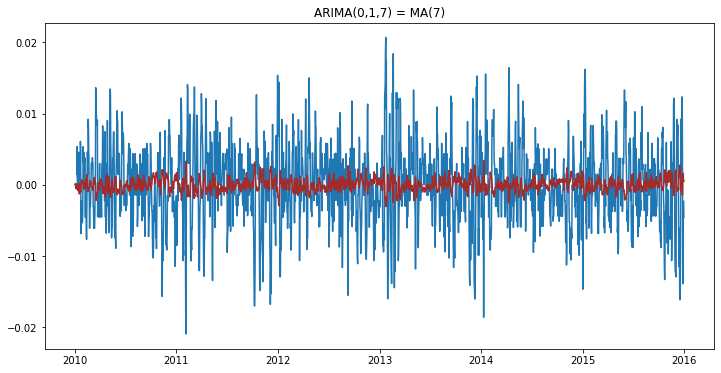

In [290]:
# Modelo MA(q): (p,d,q) = (0,1,7) 
model = ARIMA(ts_test_log, order=(0,1,7), missing='drop')
results_MA2 = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA2.fittedvalues, color='brown')
plt.title('ARIMA(0,1,7) = MA(7)')
print(results_MA2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2190
Model:                 ARIMA(2, 1, 7)   Log Likelihood                9718.115
Method:                       css-mle   S.D. of innovations              0.003
Date:                Fri, 19 Feb 2021   AIC                         -19414.231
Time:                        06:50:17   BIC                         -19351.622
Sample:                    01-02-2010   HQIC                        -19391.348
                         - 12-31-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.033e-06   2.08e-05     -0.050      0.960   -4.18e-05    3.97e-05
ar.L1.D.Tmin    -0.1862        nan        nan        nan         nan         nan
ar.L2.D.Tmin     0.1105      0.431      0.25

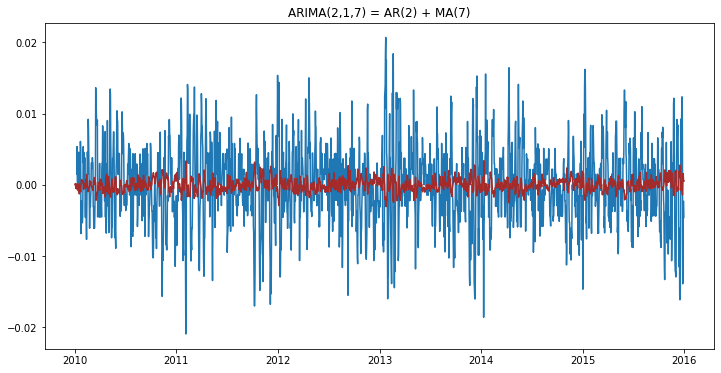

In [291]:
# Modelo ARIMA(p): (p,d,q) = (2,1,7) 
model = ARIMA(ts_test_log, order=(2,1,7), missing='drop')
results_ARIMA2 = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,7) = AR(2) + MA(7)')
print(results_ARIMA2.summary())

## Predicciones

### Temperatura Máxima

In [292]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2010-01-02   -0.001598
2010-01-03    0.034073
2010-01-04    0.125621
2010-01-05   -0.250641
2010-01-06   -0.146472
                ...   
2015-12-27    1.089169
2015-12-28    1.695738
2015-12-29    1.019318
2015-12-30    0.893440
2015-12-31    0.476889
Length: 2190, dtype: float64


In [293]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA = pd.Series(ts_test, index = ts_test.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff)
print(predictions_ARIMA.head())
print(predictions_ARIMA.tail())

Fecha
2010-01-01          NaN
2010-01-02    24.498402
2010-01-03    27.534073
2010-01-04    27.625621
2010-01-05    26.749359
dtype: float64
Fecha
2015-12-27    19.089169
2015-12-28    21.695738
2015-12-29    20.019318
2015-12-30    23.393440
2015-12-31    23.476889
dtype: float64


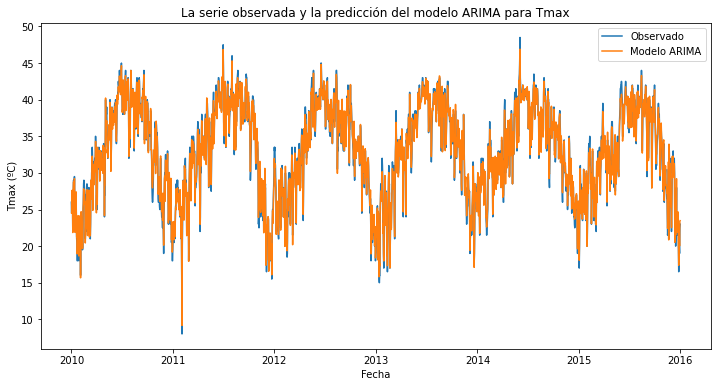

In [294]:
# Convertimos las temperaturas a grado Kelvin
def Celsius(K):
  C = K - 273.15
  return C

#predictions_ARIMA = predictions_ARIMA.apply(Celsius)
#ts_test = ts_test.apply(Celsius)

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [295]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.755194516842256


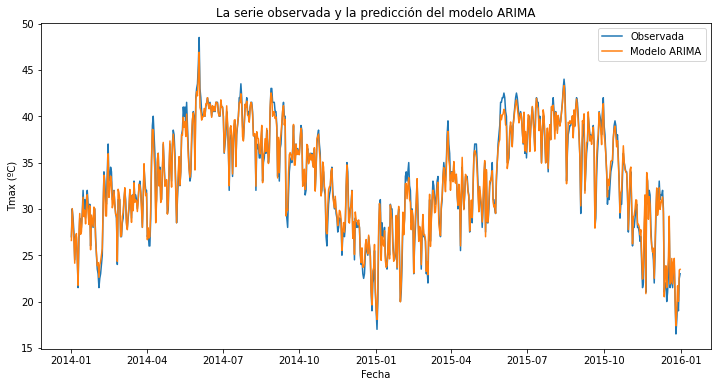

In [296]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

### Temperatura Mínima

In [297]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff2 = pd.Series(results_ARIMA2.fittedvalues, copy=True)
print(predictions_ARIMA_diff2)

Fecha
2010-01-02   -0.000001
2010-01-03    0.000175
2010-01-04   -0.000199
2010-01-05   -0.000515
2010-01-06   -0.000032
                ...   
2015-12-27    0.000428
2015-12-28    0.001574
2015-12-29    0.001244
2015-12-30    0.000479
2015-12-31    0.000534
Length: 2190, dtype: float64


In [298]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA2 = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA2 = predictions_ARIMA2.add(predictions_ARIMA_diff2)
print(predictions_ARIMA2.head())
print(predictions_ARIMA2.tail())
print(ts_test_log.head())
print(ts_test_log.tail())

Fecha
2010-01-01         NaN
2010-01-02    2.448937
2010-01-03    2.452192
2010-01-04    2.453349
2010-01-05    2.450734
dtype: float64
Fecha
2015-12-27    2.442358
2015-12-28    2.445853
2015-12-29    2.448634
2015-12-30    2.449417
2015-12-31    2.451014
dtype: float64
Fecha
2010-01-01    2.450480
2010-01-02    2.448938
2010-01-03    2.452017
2010-01-04    2.453548
2010-01-05    2.451249
Name: Tmin, dtype: float64
Fecha
2015-12-27    2.441931
2015-12-28    2.444279
2015-12-29    2.447391
2015-12-30    2.448938
2015-12-31    2.450480
Name: Tmin, dtype: float64


Fecha
2010-01-01          NaN
2010-01-02     7.999331
2010-01-03    10.114091
2010-01-04    10.869739
2010-01-05     9.165162
dtype: float64
Fecha
2015-12-27    3.772533
2015-12-28    6.010187
2015-12-29    7.803377
2015-12-30    8.310196
2015-12-31    9.346944
dtype: float64


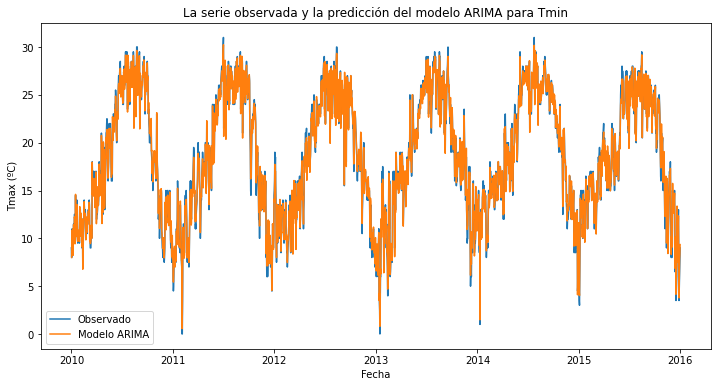

In [299]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA2 = 10**(predictions_ARIMA2)
# Graficamos la serie original y las predicciones con ARIMA

predictions_ARIMA2 = predictions_ARIMA2.apply(Celsius)
ts_test2= ts_test2.apply(Celsius)

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test2, label='Observado');
plt.plot(predictions_ARIMA2, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

print(predictions_ARIMA2.head())
print(predictions_ARIMA2.tail())


In [300]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA2 - ts_test2)**2))
print('RMSE:', RMSE)

RMSE: 0.5761490566459119


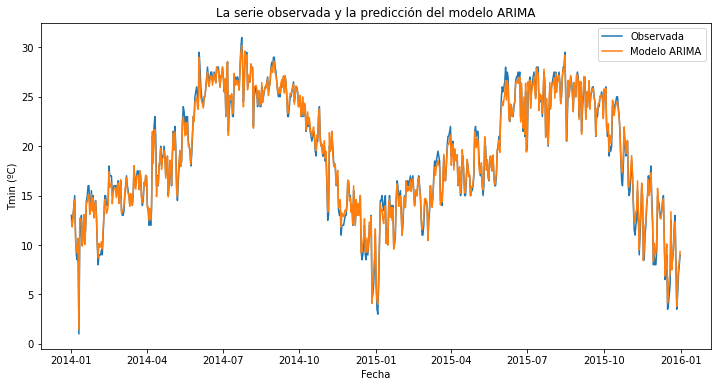

In [301]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test2.tail(730)
predictions_ARIMA_last = predictions_ARIMA2.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');